# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
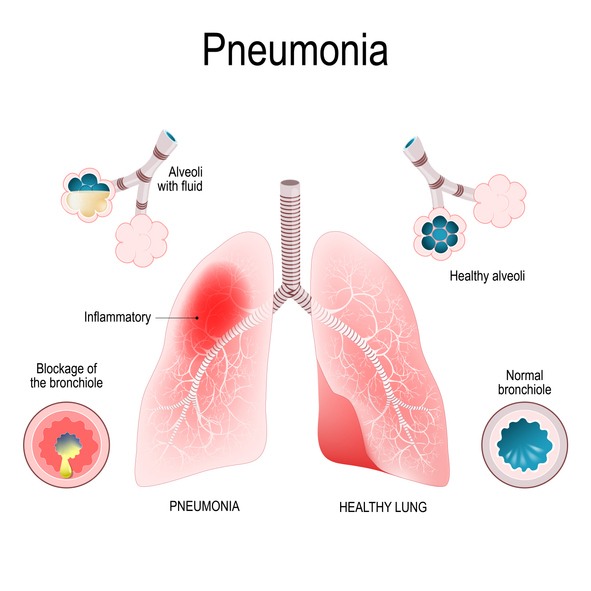

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# Importing the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

Using TensorFlow backend.


In [3]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

In [4]:
np.random.seed(42)
tf.random.set_seed(42) 

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_normal =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/*.jpeg')
train_pneumonia =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*.jpeg')

test_normal =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/*.jpeg')
test_pneumonia =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*.jpeg')

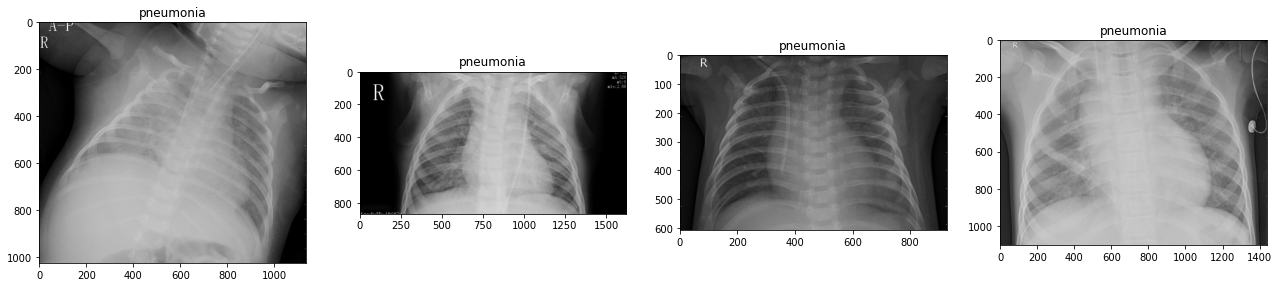

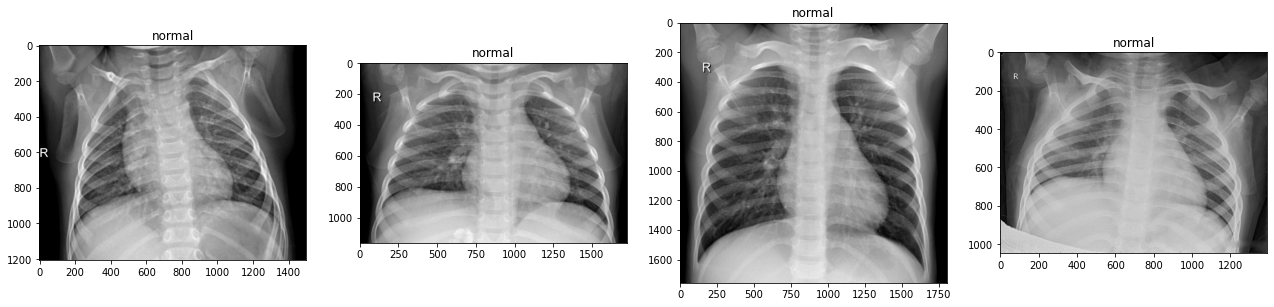

In [7]:
pneumonia =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*.jpeg')

figure, axes = plt.subplots(figsize=(22, 10), nrows=1, ncols=4)


for i in range(4):
    rand_i = np.random.randint(0, len(pneumonia))
    image = cv2.cvtColor(cv2.imread(pneumonia[rand_i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].set_title('pneumonia')

normal =glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/*.jpeg')

figure, axes = plt.subplots(figsize=(22, 10), nrows=1, ncols=4)


for i in range(4):
    rand_i = np.random.randint(0, len(normal))
    image = cv2.cvtColor(cv2.imread(normal[rand_i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].set_title('normal')

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split


# train_df
train_path = train_normal + train_pneumonia # 4000 4005 (Cat/Dog)
train_label = ["NORMAL" for _ in range(len(train_normal))] + ["PNEUMONIA" for _ in range(len(train_pneumonia))]
train_df = pd.DataFrame({"path":train_path, "label":train_label})


# test_df
test_paths = test_normal + test_pneumonia # 1011 1012 (Cat/Dog)
test_label = ["NORMAL" for _ in range(len(test_pneumonia))] + ["PNEUMONIA" for _ in range(len(test_normal))]
test_df = pd.DataFrame({"path":test_paths, "label":test_label})

# valid_df
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(train_df['label'].value_counts())
print(valid_df['label'].value_counts())

PNEUMONIA    3099
NORMAL       1073
Name: label, dtype: int64
PNEUMONIA    776
NORMAL       268
Name: label, dtype: int64


In [9]:
pd.set_option("display.max_colwidth", 200)
train_df.head()

,path,label
99,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0523-0001-0001.jpeg,NORMAL
1284,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0602-0001.jpeg,NORMAL
5142,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person611_bacteria_2476.jpeg,PNEUMONIA
1365,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1197_virus_2039.jpeg,PNEUMONIA
2649,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1023_bacteria_2954.jpeg,PNEUMONIA


In [10]:
BATCH_SIZE = 64
# train_generator
train_generator = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 20, 
                                    rescale = 1/255.0
                                    ) # 다양한 Augmentation 시도해보기!!!
train_generator_iterator = train_generator.flow_from_dataframe(dataframe=train_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=True)

# valid_generator
valid_generator = ImageDataGenerator(rescale = 1/255.0)

valid_generator_iterator = valid_generator.flow_from_dataframe(dataframe=valid_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=False)


# test_generator
test_generator = ImageDataGenerator(rescale = 1/255.0)

test_generator_iterator = test_generator.flow_from_dataframe(dataframe=test_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 5216 validated image filenames belonging to 2 classes.


In [11]:
train_batch, label_batch = next(train_generator_iterator)
train_batch.shape, label_batch.shape

((64, 224, 224, 3), (64,))

In [12]:

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool, name ):
    # 1X1 Conv
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding="same", activation="relu")(x)

    # 3X3 적용전 1X1 Conv
    reduce_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding="same", activation="relu")(x)
    # 3X3 Conv
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding="same", activation="relu")(reduce_3x3)

    # 5X5 적용전 1X1 Conv
    reduce_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding="same", activation="relu")(x)
    # 5X5 Conv
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding="same", activation="relu")(reduce_5x5)

    # Max Pooling Proj.
    pool = MaxPooling2D((3,3), strides=(1,1), padding="same")(x)
    pool_proj = Conv2D(filters_pool, (1, 1), padding="same", activation="relu")(pool)

    # Concatenate
    # (batch(axis=0), height(axis=1), width(axis=2), depth(axis=3))
    output = Concatenate(axis=-1, name=name)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output

In [13]:
IMAGE_SIZE = 150

def build_GoogLeNet():
    tf.keras.backend.clear_session()
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    x = Conv2D(filters=64, kernel_size=(7, 7), padding="same", strides=(2, 2), activation="relu")(input_tensor)
    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), padding="same", strides=(1, 1), activation="relu")(x)
    x = Conv2D(filters=192, kernel_size=(3, 3), padding="same", strides=(1, 1), activation="relu")(x)
    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)
    
    # 인셉션 모듈 3a
    x = inception_module(x, 64, 96, 128, 16, 32, 32, name="inception_3a")
    # 인셉션 모듈 3b
    x = inception_module(x, 128, 128, 192, 32, 96, 64, name="inception_3b")

    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)

    # 인셉션 모듈 4a
    x = inception_module(x, 192, 96, 208, 16, 48, 64, "inception_4a")
    # 인셉션 모듈 4b
    x = inception_module(x, 160, 112, 224, 24, 64, 64, name="inception_4b")
    # 인셉션 모듈 4c
    x = inception_module(x, 128, 128, 256, 24, 64, 64, name="inception_4c")
    # 인셉션 모듈 4d
    x = inception_module(x, 112, 144, 288, 32, 64, 64, name="inception_4d")
    # 인셉션 모듈 4e
    x = inception_module(x, 256, 160, 320, 32, 128, 128, name="inception_4e")

    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)

    # 인셉션 모듈 5a
    x = inception_module(x, 256, 160, 320, 32, 128, 128, name="inception_5a")
    # 인셉션 모듈 5b
    x = inception_module(x, 384, 192, 384, 48, 128, 128, name="inception_5b")

    x = GlobalAveragePooling2D()(x) 
    x = Dropout(0.4)(x)    
    output = Dense(units=1, activation='sigmoid')(x)


    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'] )
    return model

model = build_GoogLeNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 75, 75, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 38, 38, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 38, 38, 64)   4160        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [14]:
import os
import time
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

In [15]:
run_logdir = get_run_logdir()
checkpoint_cb = ModelCheckpoint("my_best_model.h5", monitor="val_loss", save_best_only = True, verbose=1)
early_stopping_cb = EarlyStopping( monitor="val_loss", patience=15, verbose=1, restore_best_weights=False)
reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)
tensorboard_cb = TensorBoard(run_logdir)

In [16]:
history = model.fit(train_generator_iterator, validation_data=valid_generator_iterator, epochs=40, 
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb, tensorboard_cb])

Train for 66 steps, validate for 17 steps
Epoch 1/40
65/66 [============================>.] - ETA: 1s - loss: 0.5943 - accuracy: 0.7425
Epoch 00001: val_loss improved from inf to 0.57362, saving model to my_best_model.h5
66/66 [==============================] - 150s 2s/step - loss: 0.5942 - accuracy: 0.7423 - val_loss: 0.5736 - val_accuracy: 0.7433
Epoch 2/40
65/66 [============================>.] - ETA: 1s - loss: 0.5744 - accuracy: 0.7422
Epoch 00002: val_loss improved from 0.57362 to 0.56685, saving model to my_best_model.h5
66/66 [==============================] - 104s 2s/step - loss: 0.5738 - accuracy: 0.7428 - val_loss: 0.5669 - val_accuracy: 0.7433
Epoch 3/40
65/66 [============================>.] - ETA: 1s - loss: 0.4747 - accuracy: 0.7544
Epoch 00003: val_loss improved from 0.56685 to 0.45337, saving model to my_best_model.h5
66/66 [==============================] - 104s 2s/step - loss: 0.4744 - accuracy: 0.7555 - val_loss: 0.4534 - val_accuracy: 0.8439
Epoch 4/40
65/66 [=====

In [21]:
model.evaluate(train_generator_iterator)

66/66 [==============================] - 86s 1s/step - loss: 0.0924 - accuracy: 0.9633


[0.09241602134231168, 0.96332693]

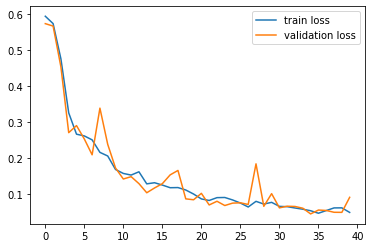

In [18]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

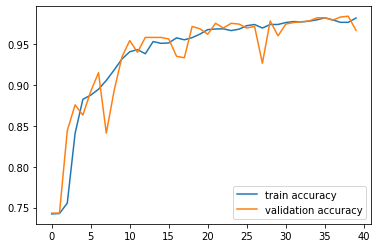

In [19]:
plt.plot(history.history['accuracy'], label="train accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

In [23]:
print("Loss of the model is - " , model.evaluate(train_generator_iterator)[0])
print("Accuracy of the model is - " , model.evaluate(train_generator_iterator)[1]*100 , "%")

66/66 [==============================] - 86s 1s/step - loss: 0.0937 - accuracy: 0.9631
Loss of the model is -  0.09373394443978075
66/66 [==============================] - 86s 1s/step - loss: 0.0923 - accuracy: 0.9650
Accuracy of the model is -  96.50048017501831 %
